In [1]:
import os
from model import *

Using TensorFlow backend.


In [2]:
deeplab_model = Deeplabv3(input_shape=(224,224,4),backbone='xception',weights=None,classes=23)
deeplab_model.load_weights('./models/deeplab_v3_s174_generate_4.hdf5')
deeplab_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 4)  0                                            
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 112, 112, 32) 1152        input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 112, 112, 32) 128         entry_flow_conv1_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 32) 0           entry_flow_conv1_1_BN[0][0]      
__________________________________________________________________________________________________
entry_flow

In [3]:
import matplotlib.pyplot as plt
def labelVisualize(num_class,color_dict,img):
    #把二维的索引数组根据索引转换为正常的rgb图片
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]

    img_out/=255.

    return img_out

#将23通道的三维数组转化为二维的索引数组
def label2image(label):
    two_array=np.zeros(label[:,:,0].shape)
    idx=np.argwhere(label==1)
    for each in idx:
        two_array[each[0],each[1]]=each[2]

    return two_array

In [4]:
# coding:utf-8
import numpy as np
import cv2
import tensorflow as tf
from libtiff import TIFF
import matplotlib.pyplot as plt
from skimage import io
img_size = 224

file_dir = './all_images/'


def get_mask(imgs):
    #输入测试图片的array，返回模型预测的array
    imgs = imgs.swapaxes(1, 2).swapaxes(2, 3)
    masks = []
    for img in imgs:
        img = np.expand_dims(img, axis=0)
        mask = deeplab_model.predict([img])
        masks.append(mask)
    return np.array(masks)


# import gdal
def readTif(file_name, isMask=False):
    #读取tif图片
#     tif = TIFF.open(file_dir + file_name)

#     image = tif.read_image()
    image=io.imread(file_dir+file_name)
    im_width = image.shape[1]
    im_height = image.shape[0]
    im_bands = 1
    if not isMask:
        im_width = image.shape[1]
        im_height = image.shape[0]
        im_bands = image.shape[2]
        image = image.swapaxes(0, 2)
        im_data = image.swapaxes(1, 2)
        image = im_data

    return {'width': im_width, 'height': im_height, 'band_num': im_bands, 'data': image}


def divide(img):
    #切割图片，同制作数据时的切割不同，现在的切割是无缝无重叠的切割
    imgs = np.array([])
    bands, height, width = img.shape
    for row in range(0, height, img_size):
        for col in range(0, width, img_size):
            if row + img_size >= height:
                row = height - img_size - 1
            if col + img_size >= width:
                col = width - img_size - 1
            imgs = np.append(imgs, img[:, row:row + img_size, col:col + img_size])
    imgs = imgs.reshape([-1, 4, 224, 224])

    return imgs


def union(imgs, height, width):
    img = np.zeros((height, width))
    id = 0
    for row in range(0, height, img_size):
        for col in range(0, width, img_size):
            if row + img_size >= height:
                row = height - img_size - 1
            if col + img_size >= width:
                col = width - img_size - 1
            img[row:row + img_size, col:col + img_size] = imgs[id]
            id += 1
    return img


/usr/local/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2573: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  tile = decompress(tile)


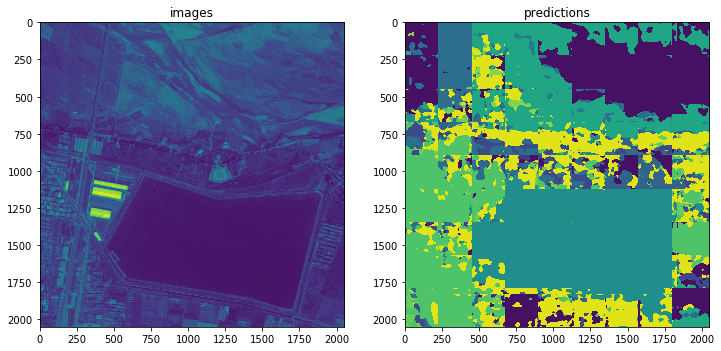

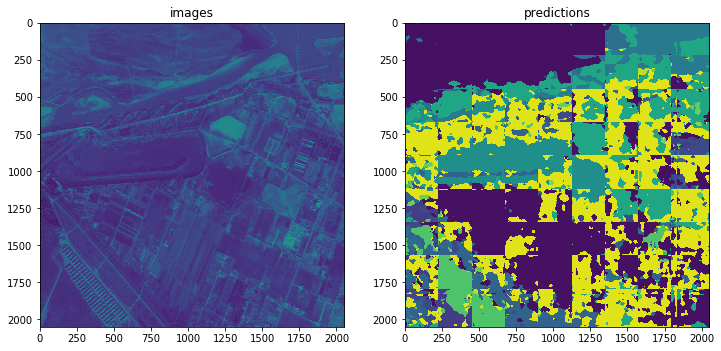

In [8]:
if not os.path.exists('./result'):
    os.mkdir('./result')
for id in range(11,13):
    # 读取原图
    img_name = '%02d.tif'%id
    img = cv2.imread('./all_images/%02d.tif'%id, -1)
#     img=cv2.imread('./test_images/03_4bands.tif',-1)
    fig = plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 2, 1)
    plt.title('images')
#     print(img)
    plt.imshow(img)

    # 先读取测试图片，将测试图片进行裁剪，然后输入到模型中进行预测得到mask，显示预测的mask图
    xs, ys = [], []
    img = readTif(img_name)
    width, height, bands, data = img['width'], img['height'], img['band_num'], img['data']
    imgs = divide(data)
    masks = get_mask(imgs)
    #np.squeeze(a,axis=None),若axis=None,则删除所有单维度
    masks = np.squeeze(masks)

    # 把MASK转化为单通道
    mask = masks.argmax(axis=-1)[..., None] == np.arange(masks.shape[-1])
    out = mask.astype('int')
    new_masks = []
    for i in range(out.shape[0]):
        mask = label2image(out[i, :, :, :])
        #若是想显示出21个颜色,则可以添加labelVisualize函数
#         ＃mask=labelVisualize()
        new_masks.append(mask)
    new_masks = np.array(new_masks)

    mask = union(new_masks, height, width)
    mask = mask.astype(np.float)
    mask /= np.max(mask)
    mask = np.uint8(255 * mask)

    fig.add_subplot(1, 2, 2)
    plt.title('predictions')
    plt.imshow(mask)
    cv2.imwrite('./result/pre_mask%02d.png'% id, mask)